# Citibike Modeling w/ WaveNet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")

In [ ]:
import numpy as np
import pandas as pd
import pickle
import random
import datetime as dt
from datetime import datetime
from datetime import timedelta
import patsy
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

from helper_functions import mae, mape, rmse, plot_forecast

## Forecast with WaveNet

In [3]:
# read pickled dataframe
citibike_df = pd.read_pickle('data/citibike_df_formatted.pkl') 

In [18]:
# head of dataframe
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,replace_zeroes,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,NaN,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,NaN,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,NaN,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,NaN,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,NaN,27


In [19]:
# create dataframe with dates as columns and stations as rows
df_all = citibike_df.pivot(index='station_id', columns='date', values='ride_counts_clean')
df_all.head()

date,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-07,2015-02-08,2015-02-09,...,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
station_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
79,15,22,15,27,27,21,16,14,15,14,15,17,34,21,29,33,17,3,15,25,31,28,36,5,24,7,19,8,14,12,6,14,5,7,14,12,12,7,8,5,...,56,34,19,71,79,67,25,28,27,10,18,54,81,64,71,35,44,12,56,44,54,41,36,47,42,28,41,33,48,26,30,52,32,19,36,55,20,19,12,42
119,3,3,3,5,5,4,8,3,4,2,3,4,4,6,5,5,1,4,2,8,7,7,5,4,4,5,1,1,5,5,3,1,1,2,4,4,4,3,1,1,...,15,24,1,12,18,15,13,10,5,1,9,17,15,13,7,16,5,5,18,10,9,16,12,25,18,18,13,8,13,7,6,22,8,5,8,10,19,13,10,9
120,4,1,4,4,4,2,1,1,1,2,3,2,6,3,5,4,8,3,9,6,1,9,6,6,7,3,4,2,2,1,3,2,2,1,4,1,2,5,6,2,...,21,36,8,27,32,30,13,13,24,7,5,13,27,52,30,23,21,9,26,12,24,14,15,27,17,9,21,8,17,21,25,22,20,10,13,26,20,15,8,21
127,41,52,19,33,65,42,45,24,32,29,31,38,67,60,68,60,39,6,61,93,61,81,78,26,52,21,7,33,40,34,21,32,5,28,32,50,34,28,30,24,...,171,122,56,186,186,134,45,40,74,30,62,130,180,184,198,87,70,39,164,130,147,132,85,89,154,65,115,84,89,64,61,79,43,18,48,69,60,44,34,88
128,24,51,13,16,76,38,44,30,41,42,36,44,74,61,68,78,46,2,64,86,89,86,88,26,48,26,13,27,21,41,34,36,7,27,55,38,41,43,35,24,...,157,133,57,181,214,138,30,54,70,39,48,104,136,137,162,126,100,30,116,117,127,92,87,109,132,55,119,75,88,54,77,78,63,21,62,69,77,39,28,81


In [0]:
# subset to only training dates - exclude all of 2019
df = df_all.loc[:, df_all.columns[:(1826-365)]]

In [0]:
# reformat column names
df = df.reset_index()
df = df.rename_axis(None)
df.columns = df.columns.astype(str)
df.columns = df.columns.astype(str).str.replace(' 00:00:00', '')

In [22]:
# head of dataframe
df.head()

date,station_id,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-07,2015-02-08,...,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
0,79,15,22,15,27,27,21,16,14,15,14,15,17,34,21,29,33,17,3,15,25,31,28,36,5,24,7,19,8,14,12,6,14,5,7,14,12,12,7,8,...,8,18,28,60,27,60,62,79,65,52,29,74,62,67,60,75,43,43,59,79,71,59,63,60,17,60,49,64,40,40,35,33,26,18,27,32,9,18,21,24
1,119,3,3,3,5,5,4,8,3,4,2,3,4,4,6,5,5,1,4,2,8,7,7,5,4,4,5,1,1,5,5,3,1,1,2,4,4,4,3,1,...,1,3,5,2,4,9,5,9,16,3,3,13,13,11,8,8,6,6,10,13,14,12,10,3,1,10,11,6,11,2,6,7,7,2,2,3,2,8,4,3
2,120,4,1,4,4,4,2,1,1,1,2,3,2,6,3,5,4,8,3,9,6,1,9,6,6,7,3,4,2,2,1,3,2,2,1,4,1,2,5,6,...,11,14,25,29,16,12,19,19,27,22,17,27,32,21,29,24,26,27,20,20,25,20,37,28,10,16,22,18,11,13,21,8,7,6,12,8,4,27,15,10
3,127,41,52,19,33,65,42,45,24,32,29,31,38,67,60,68,60,39,6,61,93,61,81,78,26,52,21,7,33,40,34,21,32,5,28,32,50,34,28,30,...,15,36,37,78,114,179,189,185,175,117,60,194,156,136,171,154,79,73,137,180,198,144,179,110,19,165,167,160,117,73,54,51,42,26,55,71,34,52,52,35
4,128,24,51,13,16,76,38,44,30,41,42,36,44,74,61,68,78,46,2,64,86,89,86,88,26,48,26,13,27,21,41,34,36,7,27,55,38,41,43,35,...,23,33,63,92,85,170,158,163,141,149,59,167,166,143,168,138,72,77,126,150,143,130,125,117,25,124,120,122,94,56,58,54,41,27,49,74,31,75,43,46


In [23]:
# date range of training data
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-01-01 to 2018-12-31


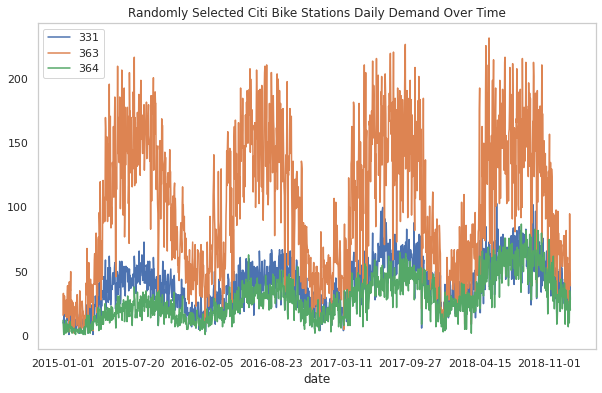

In [24]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=24)
    station_labels = sample['station_id'].tolist()
    series_samples = sample.loc[:, data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        (pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Citi Bike Stations Daily Demand Over Time')
    plt.legend(station_labels)
    
plot_random_series(df, 3)

### Train and Validation Series Partioning

**Create 4 sub-segments of the data:**.   
1. Train encoding period  
2. Train decoding period (train targets, 60 days)  
3. Validation encoding period  
4. Validation decoding period (validation targets, 60 days)  

In [25]:
print(data_start_date, "to", data_end_date)

2015-01-01 to 2018-12-31


In [0]:
pred_steps = 365 
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date) # gradually increase start end date (for overlapping windows)?

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [0]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [28]:
print('Train encoding:', train_enc_start.strftime('%Y-%m-%d'), 'to', train_enc_end.strftime('%Y-%m-%d'))
print('Train prediction:', train_pred_start.strftime('%Y-%m-%d'), 'to', train_pred_end.strftime('%Y-%m-%d'))
print('\nVal encoding:', val_enc_start.strftime('%Y-%m-%d'), 'to', val_enc_end.strftime('%Y-%m-%d'))
print('Val prediction:', val_pred_start.strftime('%Y-%m-%d'), 'to', val_pred_end.strftime('%Y-%m-%d'))

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-01-01 to 2016-12-31
Train prediction: 2017-01-01 to 2017-12-31

Val encoding: 2016-01-01 to 2017-12-31
Val prediction: 2018-01-01 to 2018-12-31

Encoding interval: 731
Prediction interval: 365


**Keras data formatting**

In [0]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):

    inds = date_to_index[start_date:end_date]
    return series_array[:, inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    
    return series_array

### CNN setup

In [0]:
# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':365})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [53]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_265 (Conv1D)             (None, None, 16)     32          input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_266 (Conv1D)             (None, None, 32)     1056        conv1d_265[0][0]                 
__________________________________________________________________________________________________
conv1d_267 (Conv1D)             (None, None, 32)     1056        conv1d_265[0][0]                 
____________________________________________________________________________________________

### Fit and train the model

In [0]:
# define early stopping with tensorflow
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [55]:
# set number of epochs
first_n_samples = 120000
batch_size = 2**11
epochs = 1000 # 100, 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Train on 145 samples, validate on 37 samples
Epoch 1/1000
145/145 [==============================] - 5s 33ms/step - loss: 0.6032 - val_loss: 0.5645
Epoch 2/1000
145/145 [==============================] - 0s 1ms/step - loss: 0.5771 - val_loss: 0.5442
Epoch 3/1000
145/145 [==============================] - 0s 1ms/step - loss: 0.5539 - val_loss: 0.5254
Epoch 4/1000
145/145 [==============================] - 0s 995us/step - loss: 0.5317 - val_loss: 0.5068
Epoch 5/1000
145/145 [==============================] - 0s 997us/step - loss: 0.5101 - val_loss: 0.4879
Epoch 6/1000
145/145 [==============================] - 0s 1ms/step - loss: 0.4871 - val_loss: 0.4690
Epoch 7/1000
145/145 [==============================] - 0s 1ms/step - loss: 0.4636 - val_loss: 0.4510
Epoch 8/1000
145/145 [==============================] - 0s 991us/step - loss: 0.4406 - val_loss: 0.4360
Epoch 9/1000
145/145 [==============================] - 0s 1ms/step - loss: 0.4221 - val_loss: 0.4282
Epoch 10/1000
145/145 [=======

In [0]:
# save trained model

# creates a HDF5 file 'my_model.h5'
model.save('wavenet_1000_epochs') 

# deletes the existing model
#del model  

# returns a compiled model identical to the previous one
#model = load_model('wavenet_1000_epochs') # wavenet_1000_epochs.h5 # wavenet_100_epochs

# check its architecture
#model.summary()

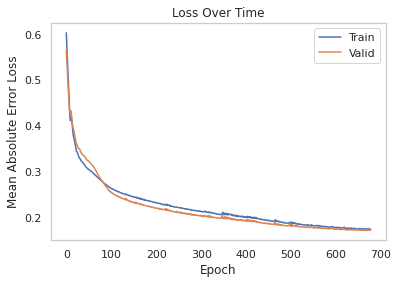

In [57]:
# plot convergence curve of train / validation loss - 1000 EPOCHS (678/1000, loss: 0.1741 - val_loss: 0.1727)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid']);

### Prepare to generate predictions

In [0]:
# get and transform encoder and decoder data for both input and target

encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [0]:
# function to generate predictions by running our model with inference loop
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [0]:
# function to add encode series mean back to encoder input data, then take inverse logp
def inverse_transform(encoder_input_data, encode_series_mean):
    encode_series_mean = np.expand_dims(encode_series_mean, axis=1)
    encoder_input_data = np.add(encoder_input_data, encode_series_mean)
    encoder_input_data = np.expm1(encoder_input_data) 
    return encoder_input_data

### Forecast select stations

In [ ]:
#stations 491, 379 and 499
print("index for station 491:", df_all.index.get_loc(491))
print("index for station 379:", df_all.index.get_loc(379))
print("index for station 499:", df_all.index.get_loc(499))

#### E 24 St & Park Ave S

MAE:  89.88544
MAPE:  51.59844
RMSE:  128.58106


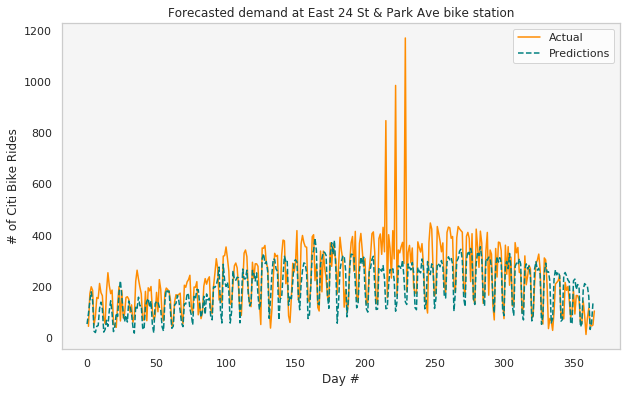

In [0]:
# CNN model: calculate and plot predictions vs actual for station 491 (index 153)
encode_series = encoder_input_data[153:153+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[153]).squeeze()
y_actual = df_all.iloc[153,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at East 24 St & Park Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

#### W 31 St 7 Ave

MAE:  82.67527190282011
MAPE:  52.58891134122137
RMSE:  106.1399509029016


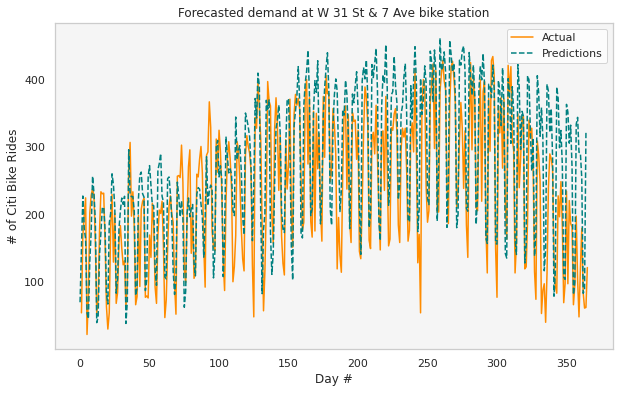

In [64]:
# CNN model: calculate and plot predictions vs actual for station 379 (index 98)
encode_series = encoder_input_data[98:98+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[98]).squeeze()
y_actual = df_all.iloc[98,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at W 31 St & 7 Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred)) #.round(5))
print('MAPE: ', mape(y_actual, y_pred)) #.round(5))
print('RMSE: ', rmse(y_actual, y_pred)) #.round(5))     

#### Broadway & W 60 St

MAE:  87.51000958614543
MAPE:  61.140371847486854
RMSE:  109.71479099428994


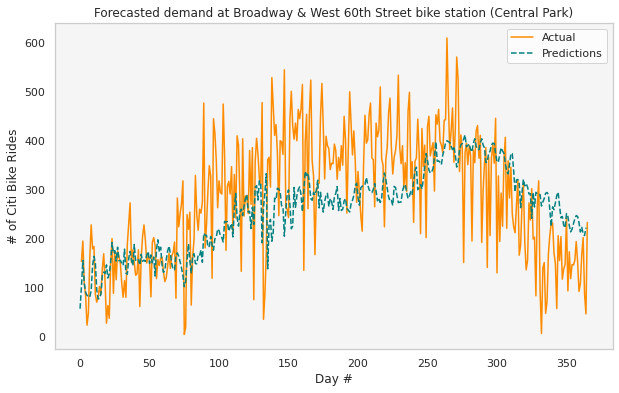

In [66]:
# CNN model: calculate and plot predictions vs actual for station 499 (index 158) 
encode_series = encoder_input_data[158:158+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[158]).squeeze()
y_actual = df_all.iloc[158,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at Broadway & West 60th Street bike station (Central Park)')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred)) #.round(5))
print('MAPE: ', mape(y_actual, y_pred)) #.round(5))
print('RMSE: ', rmse(y_actual, y_pred)) #.round(5))     

### Forecast all stations

In [81]:
# CNN model: calculate predictions and avg mae / mape for all 182 stations - COLAB

mape_dict = {}
mae_dict = {}
rmse_dict = {}

for index in range(182): 
  encode_series = encoder_input_data[index:index+1,:,:]
  pred_series = predict_sequence(encode_series)
  y_pred = inverse_transform(pred_series, encode_series_mean[index]).squeeze()
  y_actual = df_all.iloc[index,-365:]

  # evaluation metrics
  mape_dict[index] = mape(y_actual, y_pred)
  mae_dict[index] = mae(y_actual, y_pred)
  rmse_dict[index] = rmse(y_actual, y_pred)
  
print('Mean MAPE: ', np.array(list(mape_dict.values())).mean()) #.round(5))  
print('Mean MAE: ', np.array(list(mae_dict.values())).mean()) #.round(5))
print('Mean RMSE: ', np.array(list(rmse_dict.values())).mean()) #.round(5))   

Mean MAPE:  71.83808987318723
Mean MAE:  51.04319456168162
Mean RMSE:  64.97270021841709
